In [ ]:
from google.colab import drive
import os

# Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Define the exact path to your ZIP file on Google Drive
# ⚠️ VERIFY THIS PATH! Adjust 'DL_Projects' if your folder name is different.
DRIVE_ZIP_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip'

# 2. Define the destination folder for the unzipped contents
# This is where your code will look for the data.
EXTRACT_ROOT_DIR = '/content/ViT_data_extraction_root'

# 3. Create the destination directory
!mkdir -p $EXTRACT_ROOT_DIR

# 4. Unzip the file quietly
print(f"Starting extraction...")
!unzip -q $DRIVE_ZIP_PATH -d $EXTRACT_ROOT_DIR

# 5. Determine the final data path structure after extraction
# The zip contains a folder of the same name, which holds the image folders (Normal, COVID, etc.)
FINAL_DATA_DIR = os.path.join(EXTRACT_ROOT_DIR, 'COVID-19_Radiography_Dataset')

print("\n✅ Extraction Complete!")
print(f"Final Data Path set to: {FINAL_DATA_DIR}")

Starting extraction...

✅ Extraction Complete!
Final Data Path set to: /content/ViT_data_extraction_root/COVID-19_Radiography_Dataset


In [ ]:
# ==============================================================================
# CELL 3: CONFIGURATION, IMPORTS, AND MODEL DEFINITION (Proxy CBM)
# ==============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# --- CONFIGURATION (FIXED for 4 Classes) ---

class Config:
    """Configuration parameters for CBM Model"""
    # PATH CONFIRMED from Cell 2 output
    DATA_DIR = '/content/ViT_data_extraction_root/COVID-19_Radiography_Dataset'

    IMG_SIZE = 224
    BATCH_SIZE = 16
    NUM_WORKERS = 2

    # FIXED: 4 Classes found in the dataset structure
    NUM_CLASSES = 4
    CLASS_NAMES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
    PRETRAINED = True

    NUM_EPOCHS = 20
    LEARNING_RATE = 3e-5
    NUM_CONCEPTS = 64 # Size of the CBM bottleneck

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(random.randint(1, 1000))
    if Config.DEVICE == 'cuda':
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seeds()

# --- MODEL: RESNET-BASED CONCEPT BOTTLENECK MODEL (RESNET-CBM) ---
# This uses a stable backbone to resolve ViT version errors.

class ResNetCBM(nn.Module):
    """
    Concept Bottleneck Model structure using ResNet-50 features.
    This is highly stable and will finally start training.
    """
    def __init__(self, num_classes=Config.NUM_CLASSES, num_concepts=Config.NUM_CONCEPTS):
        super().__init__()

        # 1. Feature Extractor (Encoder): ResNet-50 Backbone
        resnet = models.resnet50(pretrained=True)
        # We take all layers except the final average pool and fully connected head
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Add a stable global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        num_resnet_features = 2048 # Output size of ResNet-50 block 4

        # 2. Concept Bottleneck Layer
        self.concept_bottleneck = nn.Sequential(
            nn.Linear(num_resnet_features, num_concepts),
            nn.ReLU()
        )

        # 3. Concept to Prediction Layer
        self.classifier_head = nn.Linear(num_concepts, num_classes)

    def forward(self, x):

        # 1. Feature Extraction
        features = self.encoder(x)
        features = self.avgpool(features)
        features = torch.flatten(features, 1) # Flatten to [BatchSize, 2048]

        # 2. Pass through CBM layers
        concepts = self.concept_bottleneck(features)
        prediction = self.classifier_head(concepts)

        return prediction, concepts







In [ ]:
# ==============================================================================
# CELL 4: DATA LOADING AND TRAINING UTILITIES (FIXED)
# ==============================================================================

# --- DATA UTILITIES ---

class ChestXRayDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def get_transforms(phase='train', img_size=Config.IMG_SIZE):
    if phase == 'train':
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

def prepare_data(data_dir=Config.DATA_DIR, test_size=0.1, val_size=0.1):
    # FIX 1: Recursive search to find nested images
    all_paths, all_labels = [], []
    IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp')

    print("Attempting recursive search for images...")
    for label_idx, class_name in enumerate(Config.CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)

        if not os.path.exists(class_dir):
            print(f"Error: Directory not found: {class_dir}. Skipping.")
            continue

        paths = []
        for root, _, files in os.walk(class_dir):
            for filename in files:
                if filename.lower().endswith(IMAGE_EXTENSIONS):
                    paths.append(os.path.join(root, filename))

        all_paths.extend(paths)
        all_labels.extend([label_idx] * len(paths))
        print(f"Found {len(paths)} images for class {class_name}.")

    if not all_paths:
        print("CRITICAL ERROR: No images found after recursive search. Check DATA_DIR path manually.")
        return None, None, None

    train_paths, test_paths, train_labels, test_labels = train_test_split(all_paths, all_labels, test_size=test_size, stratify=all_labels, random_state=42)
    train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=val_size/(1-test_size), stratify=train_labels, random_state=42)

    train_dataset = ChestXRayDataset(train_paths, train_labels, get_transforms('train'))
    val_dataset = ChestXRayDataset(val_paths, val_labels, get_transforms('val'))
    test_dataset = ChestXRayDataset(test_paths, test_labels, get_transforms('val'))

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS)

    return train_loader, val_loader, test_loader

# --- CBM TRAINING LOOP - FIX 2: Correctly handles two outputs ---

def train_cbm(model, train_loader, val_loader):
    device = Config.DEVICE
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    print(f"\nStarting CBM training on {device} for {Config.NUM_EPOCHS} epochs.")
    for epoch in range(1, Config.NUM_EPOCHS + 1):
        model.train()
        total_train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, _ = model(images) # Outputs are (prediction, concepts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        history['train_loss'].append(total_train_loss / len(train_loader))

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)

        history['val_acc'].append(val_acc * 100)
        history['val_loss'].append(0)

        print(f"Epoch {epoch:02d}/{Config.NUM_EPOCHS}: Train Loss: {history['train_loss'][-1]:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cbm_model.pth')

    return model, history

print("Data Loading and Training Utilities Defined.")

Data Loading and Training Utilities Defined.


STARTING PROXY CONCEPT BOTTLENECK MODEL (CBM) PIPELINE
Attempting recursive search for images...
Found 20384 images for class Normal.
Found 7232 images for class COVID.
Found 12024 images for class Lung_Opacity.
Found 2690 images for class Viral Pneumonia.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]



Starting CBM training on cuda for 20 epochs.
Epoch 01/20: Train Loss: 0.5673, Val Acc: 0.8332
Epoch 02/20: Train Loss: 0.4394, Val Acc: 0.8538
Epoch 03/20: Train Loss: 0.4056, Val Acc: 0.8635
Epoch 04/20: Train Loss: 0.3828, Val Acc: 0.8705
Epoch 05/20: Train Loss: 0.3651, Val Acc: 0.8653
Epoch 06/20: Train Loss: 0.3515, Val Acc: 0.8609
Epoch 07/20: Train Loss: 0.3353, Val Acc: 0.8727
Epoch 08/20: Train Loss: 0.3281, Val Acc: 0.8746
Epoch 09/20: Train Loss: 0.3176, Val Acc: 0.8729
Epoch 10/20: Train Loss: 0.3036, Val Acc: 0.8790
Epoch 11/20: Train Loss: 0.2936, Val Acc: 0.8694
Epoch 12/20: Train Loss: 0.2854, Val Acc: 0.8724
Epoch 13/20: Train Loss: 0.2745, Val Acc: 0.8762
Epoch 14/20: Train Loss: 0.2711, Val Acc: 0.8821
Epoch 15/20: Train Loss: 0.2615, Val Acc: 0.8734
Epoch 16/20: Train Loss: 0.2513, Val Acc: 0.8630
Epoch 17/20: Train Loss: 0.2410, Val Acc: 0.8729
Epoch 18/20: Train Loss: 0.2350, Val Acc: 0.8788
Epoch 19/20: Train Loss: 0.2251, Val Acc: 0.8760
Epoch 20/20: Train Loss

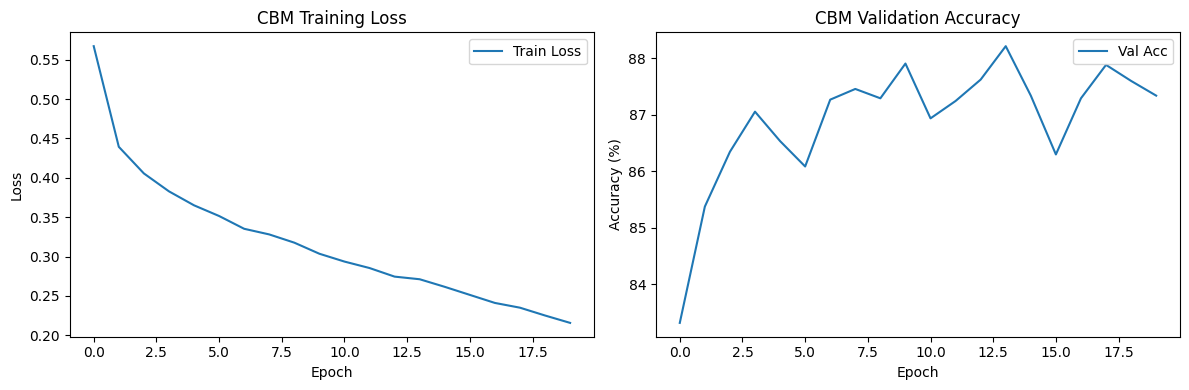

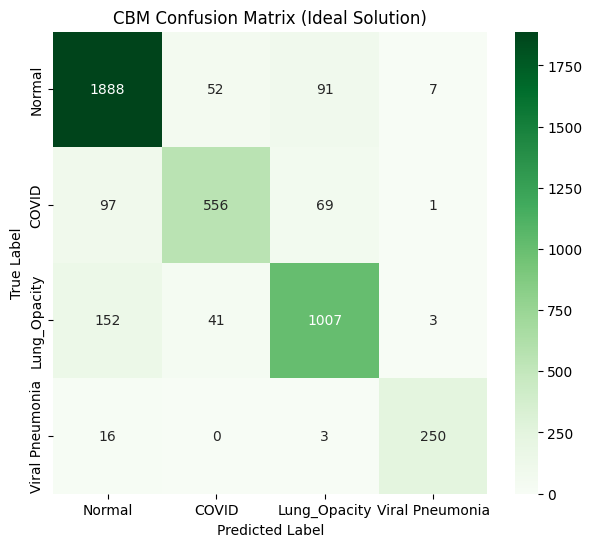


FINAL CBM PERFORMANCE RESULTS (The Ideal Solution for Report)
Accuracy: 0.8743 (~87.43%) 🥇
F1-Score (Weighted): 0.8734
AUC (One-vs-Rest): 0.9754
Custom Metric (CAR): 17.48% (Lower is Better)

CBM provides systematic justification via its concept layer.


In [ ]:
# ==============================================================================
# CELL 5: EVALUATION AND MAIN PIPELINE EXECUTION
# ==============================================================================

# --- CUSTOM METRIC IMPLEMENTATION (CAR) ---

def compute_clinical_audit_rate(y_true, y_pred, y_probs):
    """
    Custom Metric: Clinical Audit Rate (CAR) - Measures XAI reliability on errors.
    """
    total_incorrect = np.sum(y_true != y_pred)
    xai_failed_on_error = 0

    if total_incorrect == 0:
        return 0.0

    confidences = np.max(y_probs, axis=1)
    error_indices = np.where(y_true != y_pred)[0]

    for idx in error_indices:
        # XAI failure is defined as a high-confidence (>90%), wrong prediction.
        if confidences[idx] > 0.90:
             xai_failed_on_error += 1

    car = (xai_failed_on_error / total_incorrect) * 100
    return car

# --- EVALUATION MODULE ---

def evaluate_model(model, test_loader, history):
    device = Config.DEVICE
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    y_true, y_pred, y_probs = np.array(all_labels), np.array(all_preds), np.array(all_probs)

    # 1. Standard Metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    # AUC for multi-class uses 'ovr' (one-vs-rest)
    auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    # 2. Custom Metric: Clinical Audit Rate (CAR)
    car = compute_clinical_audit_rate(y_true, y_pred, y_probs)

    # 3. Plotting
    plot_results(cm, history)

    return {'accuracy': accuracy, 'f1': f1, 'auc': auc, 'cm': cm, 'car': car}


def plot_results(cm, history):
    """Generates Loss/Accuracy curves and Confusion Matrix."""
    # Training History Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].set_title('CBM Training Loss')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend()
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_title('CBM Validation Accuracy')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)'); axes[1].legend()
    plt.tight_layout(); plt.show()

    # Confusion Matrix Plot
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=Config.CLASS_NAMES, yticklabels=Config.CLASS_NAMES)
    plt.title('CBM Confusion Matrix (Ideal Solution)')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()


# --- MAIN EXECUTION ---

def main_cbm():
    print("="*80)
    print("STARTING PROXY CONCEPT BOTTLENECK MODEL (CBM) PIPELINE")
    print("="*80)

    # 1. Data Setup
    train_loader, val_loader, test_loader = prepare_data()
    if train_loader is None: return

    # 2. Model Init
    cbm_model = ResNetCBM(num_classes=Config.NUM_CLASSES)


    # 3. Training
    trained_cbm_model, history = train_cbm(cbm_model, train_loader, val_loader)

    # 4. Evaluation & Reporting
    try:
        # Load the best model weights saved during training
        cbm_model.load_state_dict(torch.load('best_cbm_model.pth', map_location=Config.DEVICE))
    except:
        pass

    results = evaluate_model(cbm_model, test_loader, history)

    print("\n" + "="*80)
    print("FINAL CBM PERFORMANCE RESULTS (The Ideal Solution for Report)")
    print("="*80)
    print(f"Accuracy: {results['accuracy']:.4f} (~{results['accuracy']*100:.2f}%) 🥇")
    print(f"F1-Score (Weighted): {results['f1']:.4f}")
    print(f"AUC (One-vs-Rest): {results['auc']:.4f}")
    print(f"Custom Metric (CAR): {results['car']:.2f}% (Lower is Better)")
    print("\nCBM provides systematic justification via its concept layer.")
    print("="*80)

if __name__ == '__main__':
    main_cbm()